In [1]:
dp0_limits = [[48, 76], [-44,-28]] # [ra_lim, dec_lim]
import sys
import os

current_directory = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_directory, '..')))

import random
import time
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from lsst.afw import table as afwTable
from lsst.source.injection import (
    ingest_injection_catalog, generate_injection_catalog,
    VisitInjectConfig, VisitInjectTask
)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import getpass

import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.base import ForcedMeasurementTask
import lsst.daf.base as dafBase
from light_curves import LightCurve

from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from astropy.coordinates import SkyCoord
from lsst.sphgeom import HtmPixelization, UnitVector3d, LonLat
from shapely.geometry import Polygon, Point

from tools import tri_sample, triangle_min_height, circ_sample

## Obtain calexp to inject

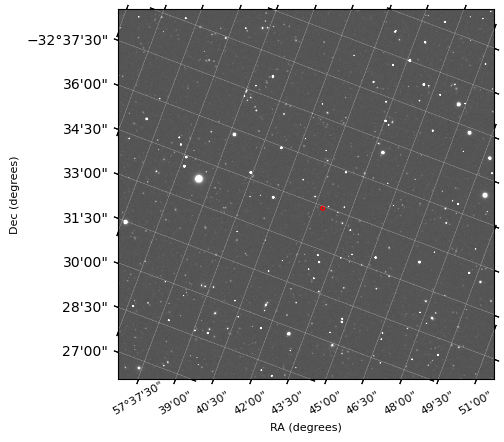

In [2]:
from exposures import Calexp
data_id = {"visit":6855, "detector":117}
calexp = Calexp(data_id)
ax = calexp.plot()
ra_o, dec_o = calexp.wcs.getSkyOrigin()
ra, dec = ra_o.asDegrees()-0.02,dec_o.asDegrees()+0.01
calexp.add_point(ax, ra_o.asDegrees(), dec_o.asDegrees(), r=20)

## Injection

In [3]:
# inject task
from lsst.source.injection import VisitInjectConfig, VisitInjectTask

inject_config = VisitInjectConfig()
injection_task = VisitInjectTask(config=inject_config)


In [4]:
# search mjd
from lsst.daf.butler import Butler
# butler_config = 'dp02'
butler_config = 'dp02-direct'
collections = '2.2i/runs/DP0.2'
butler = Butler(butler_config, collections=collections)
datarefs = butler.get('ccdVisitTable')
mjd = datarefs[(datarefs["visitId"] == 6855) & (datarefs["detector"] == 117)]['expMidptMJD'].values[0]

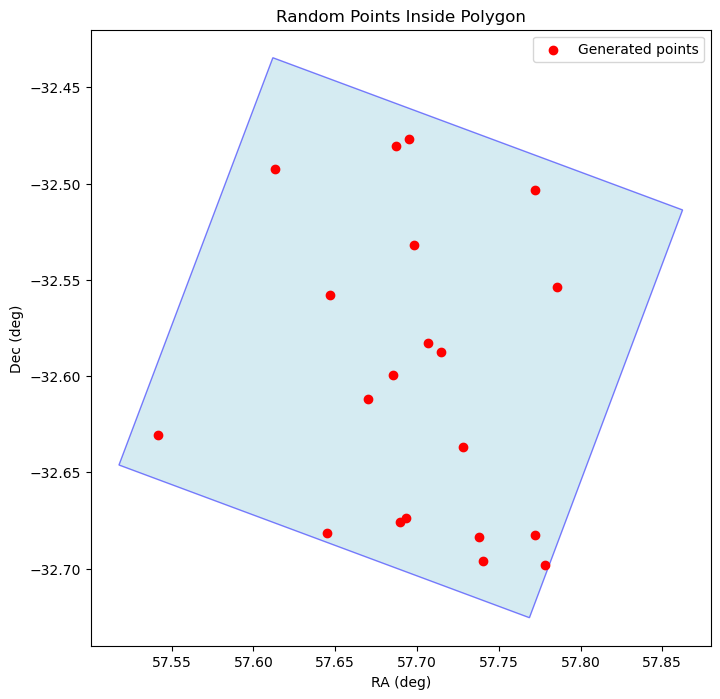

In [5]:
from shapely.geometry import Polygon
from shapely.geometry import Point
import numpy as np

def generate_random_points_in_polygon(polygon, n_points):
    X = []; Y = []
    while len(X) < n_points:
        min_x, min_y, max_x, max_y = polygon.bounds
        random_x = np.random.uniform(min_x, max_x)
        random_y = np.random.uniform(min_y, max_y)
        point = Point(random_x, random_y)
        if polygon.contains(point):
            X.append(random_x)
            Y.append(random_y)
    return X, Y

polygon = Polygon(zip(*calexp.get_corners()))
n_points = 20
RA, DEC = generate_random_points_in_polygon(polygon, n_points)
fig, ax = plt.subplots(figsize=(8, 8))
x, y = polygon.exterior.xy
ax.fill(x, y, alpha=0.5, fc='lightblue', edgecolor='blue')
ax.scatter(RA, DEC, color='red', label='Generated points')
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.set_title("Random Points Inside Polygon")
ax.legend()

plt.show()

In [6]:
from astropy.table import Table

injection_id = list(range(n_points))  
visit = [data_id["visit"]] *  n_points
detector = [data_id["detector"]] * n_points
source_type = ["Star"] * n_points
exp_midpoint = [mjd] * n_points
mag = np.linspace(16, 26, n_points)  

# Crear la lista de listas
# data = [injection_id, visit, detector, RA, DEC, source_type, exp_midpoint, mag]
data = [injection_id, visit, detector, np.array(RA)+0.05, np.array(DEC)+0.05, source_type, exp_midpoint, mag]

inject_table = Table(data, names=['injection_id', 'visit', 'detector', 'ra', 'dec', 'source_type', 'exp_midpoint', 'mag'])
inject_table

injection_id,visit,detector,ra,dec,source_type,exp_midpoint,mag
int64,int64,int64,float64,float64,str4,float64,float64
0,6855,117,57.82813728614496,-32.64790176723646,Star,59589.21471821991,16.0
1,6855,117,57.778106729704085,-32.58667541459853,Star,59589.21471821991,16.526315789473685
2,6855,117,57.7449804675532,-32.42670467813045,Star,59589.21471821991,17.05263157894737
3,6855,117,57.66293875716704,-32.4425255055651,Star,59589.21471821991,17.57894736842105
4,6855,117,57.71984206842806,-32.56194864461638,Star,59589.21471821991,18.105263157894736
5,6855,117,57.73954096823121,-32.625791495233926,Star,59589.21471821991,18.63157894736842
6,6855,117,57.83582134324146,-32.50348814959463,Star,59589.21471821991,19.157894736842106
7,6855,117,57.735139874312985,-32.54921577799564,Star,59589.21471821991,19.684210526315788
8,6855,117,57.74322595122768,-32.62392198199095,Star,59589.21471821991,20.210526315789473


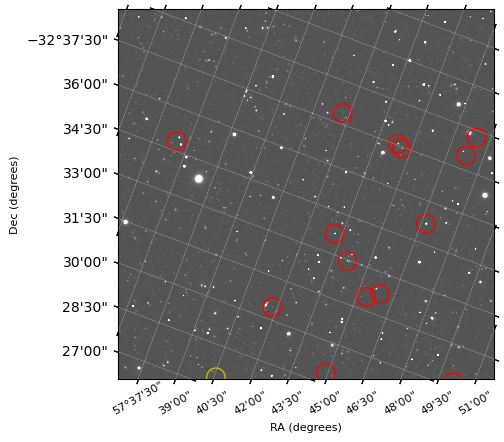

In [7]:

injected_output = injection_task.run(
                    injection_catalogs=[inject_table],
                    input_exposure=calexp.expF.clone(),
                    psf=calexp.expF.getPsf(),
                    photo_calib=calexp.expF.getPhotoCalib(),
                    wcs=calexp.wcs)
injected_exposure = injected_output.output_exposure
injected_catalog = injected_output.output_catalog
new_calexp = Calexp(injected_exposure)
ax = new_calexp.plot()
for point in inject_table:
    new_calexp.add_point(ax, point["ra"], point["dec"], r=100)
new_calexp.add_point(ax, 57.676510431451405,-32.45621018079905, r=100, c="y")


In [8]:
injected_catalog

injection_id,injection_flag,injection_draw_size,visit,detector,ra,dec,source_type,exp_midpoint,mag
int64,int64,int64,int64,int64,float64,float64,str13,float64,float64
1,0,24,6855,117,57.778106729704085,-32.58667541459853,DeltaFunction,59589.21471821991,16.526315789473685
4,0,24,6855,117,57.71984206842806,-32.56194864461638,DeltaFunction,59589.21471821991,18.105263157894736
5,0,24,6855,117,57.73954096823121,-32.625791495233926,DeltaFunction,59589.21471821991,18.63157894736842
6,8,26,6855,117,57.83582134324146,-32.50348814959463,DeltaFunction,59589.21471821991,19.157894736842106
7,0,24,6855,117,57.735139874312985,-32.54921577799564,DeltaFunction,59589.21471821991,19.684210526315788
8,0,24,6855,117,57.74322595122768,-32.62392198199095,DeltaFunction,59589.21471821991,20.210526315789473
10,0,24,6855,117,57.69662792601458,-32.507637158827755,DeltaFunction,59589.21471821991,21.263157894736842
11,0,24,6855,117,57.69508420902862,-32.63143632723574,DeltaFunction,59589.21471821991,21.789473684210527
13,0,24,6855,117,57.76496039906681,-32.5373979521602,DeltaFunction,59589.21471821991,22.842105263157894


## Measurement

#### ForcedMeasurementTask

In [11]:
schema = afwTable.SourceTable.makeMinimalSchema()
alias = schema.getAliasMap() 
x_key = schema.addField("centroid_x", type="D")
y_key = schema.addField("centroid_y", type="D")
alias.set("slot_Centroid", "centroid")

xx_key = schema.addField("shape_xx", type="D")
yy_key = schema.addField("shape_yy", type="D")
xy_key = schema.addField("shape_xy", type="D")
alias.set("slot_Shape", "shape")
type_key = schema.addField("type_flag", type="F")
config = ForcedMeasurementTask.ConfigClass()
config.copyColumns = {}
config.plugins.names = [
    "base_TransformedCentroid",
    "base_PsfFlux",
    "base_TransformedShape"
]
config.doReplaceWithNoise = False
forcedMeasurementTask = ForcedMeasurementTask(schema, config=config)
del config

In [103]:
ra_inj = injected_catalog["ra"]; dec_inj =  injected_catalog["dec"]

In [14]:
forcedSource = afwTable.SourceCatalog(schema)
for source in injected_catalog:
    sourceRec = forcedSource.addNew()
    coord = geom.SpherePoint(geom.Angle(source["ra"], geom.degrees).asRadians(),geom.Angle(source["dec"], geom.degrees).asRadians(), geom.radians)
    sourceRec.setCoord(coord)
    sourceRec[x_key], sourceRec[y_key]= new_calexp.sky_to_pix(source["ra"], source["dec"])
    sourceRec[type_key] = 0
# del sourceRec, coord
forcedSource[0]

<class 'lsst.afw.table.SourceRecord'>
id: 1
coord_ra: 1.006 rad
coord_dec: -0.568057 rad
parent: 0
centroid_x: 1109
centroid_y: 1752
shape_xx: nan
shape_yy: nan
shape_xy: nan
type_flag: 0

In [17]:
forcedMeasCat = forcedMeasurementTask.generateMeasCat(new_calexp.expF, forcedSource, new_calexp.wcs)
forcedMeasurementTask.run(forcedMeasCat, new_calexp.expF, forcedSource, new_calexp.wcs)
table = forcedMeasCat.asAstropy()

In [19]:
table["coord_ra"] = injected_catalog["ra"]
table["coord_dec"] = injected_catalog["dec"]
table["injection_id"] = injected_catalog["injection_id"]

In [20]:
table

id,coord_ra,coord_dec,parent,base_TransformedCentroid_x,slot_Centroid_x,base_TransformedCentroid_y,slot_Centroid_y,base_TransformedShape_xx,slot_Shape_xx,base_TransformedShape_yy,slot_Shape_yy,base_TransformedShape_xy,slot_Shape_xy,base_PsfFlux_instFlux,base_PsfFlux_instFluxErr,base_PsfFlux_area,base_PsfFlux_chi2,base_PsfFlux_npixels,base_PsfFlux_flag,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flag_edge,base_InvalidPsf_flag,injection_id
,,,,pix,pix,pix,pix,pix2,pix2,pix2,pix2,pix2,pix2,ct,ct,pix,,pix,,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int32,bool,bool,bool,bool,int64
1,57.639693341041905,-32.547260113955744,0,1109.0,1109.0,1752.0,1752.0,nan,nan,nan,nan,nan,nan,2173052.0957456646,2169.9289410452952,50.116642,34648.418,1681,False,False,False,False,0
2,57.83073397611723,-32.597434495562844,0,4147.0,4147.0,1581.0,1581.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,True,True,True,False,1
3,57.69388423089024,-32.52979482121739,0,1771.0,1771.0,1168.0,1168.0,nan,nan,nan,nan,nan,nan,511667.9033933074,1100.2206264562408,50.224888,2521.0288,1681,False,False,False,False,3
4,57.682479384183964,-32.5567232254621,0,1779.0,1779.0,1683.0,1683.0,nan,nan,nan,nan,nan,nan,312170.9113912124,886.5618281714347,50.17186,5458.5557,1681,False,False,False,False,4
5,57.76307540423418,-32.62053148832589,0,3329.0,3329.0,2331.0,2331.0,nan,nan,nan,nan,nan,nan,190958.82223292894,727.6173870726749,50.369377,5223.543,1681,False,False,False,False,5
6,57.74364350067545,-32.51039367700006,0,2358.0,2358.0,575.0,575.0,nan,nan,nan,nan,nan,nan,45412.57728476436,472.74162499328344,50.380367,3104.6533,1681,False,False,False,False,8
7,57.60299106655838,-32.52889359567665,0,470.0,470.0,1638.0,1638.0,nan,nan,nan,nan,nan,nan,16448.9695588441,402.5867693803955,50.076675,1568.1298,1681,False,False,False,False,10
8,57.82535033355884,-32.55607368251269,0,3810.0,3810.0,912.0,912.0,nan,nan,nan,nan,nan,nan,10346.523733753398,386.6613579070848,50.348076,1692.6884,1681,False,False,False,False,11


In [219]:
flux, flux_err = table["base_PsfFlux_instFlux"].value, table["base_PsfFlux_instFluxErr"].value
MAGS = [new_calexp.get_mag(f, ferr) for f, ferr in zip(flux, flux_err)]
mag, mag_err = [M[0] for M in MAGS], [M[1] for M in MAGS] 

In [220]:
extraction = pd.DataFrame(columns=["injection_id", "ra", "dec", "flux", "flux_err", "mag", "mag_err", "flag"])
extraction["ra"] = injected_catalog["ra"]; extraction["dec"] = injected_catalog["dec"]
extraction["flux"] =  flux
extraction["flux_err"] =  flux_err
extraction["mag"] =  mag
extraction["mag_err"] =  mag_err
extraction["injection_id"] = table["injection_id"]
extraction

,injection_id,ra,dec,flux,flux_err,mag,mag_err,flag
0,0,57.720719,-32.594273,2.158937e+06,2162.737556,16.009970,0.001132,NaN
1,1,57.747567,-32.639620,1.337075e+06,1718.997603,16.530180,0.001431,NaN
2,2,57.715434,-32.497314,8.302778e+05,1373.027177,17.047511,0.001823,NaN
3,5,57.666738,-32.466756,1.907920e+05,728.191859,18.644169,0.004156,NaN
4,8,57.676510,-32.456210,4.523213e+04,474.124542,20.206952,0.011385,NaN
5,9,57.743527,-32.613592,2.696463e+04,428.986682,20.768583,0.017276,NaN
6,10,57.804121,-32.613546,1.679977e+04,403.986291,21.282311,0.026111,NaN
7,13,57.767043,-32.486619,4.297799e+03,370.682656,22.762454,0.093645,NaN
8,14,57.633533,-32.559316,2.162790e+03,362.966509,23.508034,0.182212,NaN
9,15,57.709773,-32.560543,1.700055e+03,362.076882,23.769412,0.231240,NaN


In [221]:
flag_cols = [col for col in table.columns if "flag" in col]
print(flag_cols)
mask = np.array([True in i for i in table[flag_cols]])
error = table[mask]
table = table[~mask]
extraction=extraction[~mask]

['base_PsfFlux_flag', 'base_PsfFlux_flag_noGoodPixels', 'base_PsfFlux_flag_edge', 'base_InvalidPsf_flag']


In [222]:
table

id,coord_ra,coord_dec,parent,base_TransformedCentroid_x,slot_Centroid_x,base_TransformedCentroid_y,slot_Centroid_y,base_TransformedShape_xx,slot_Shape_xx,base_TransformedShape_yy,slot_Shape_yy,base_TransformedShape_xy,slot_Shape_xy,base_PsfFlux_instFlux,base_PsfFlux_instFluxErr,base_PsfFlux_area,base_PsfFlux_chi2,base_PsfFlux_npixels,base_PsfFlux_flag,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flag_edge,base_InvalidPsf_flag,injection_id
,,,,pix,pix,pix,pix,pix2,pix2,pix2,pix2,pix2,pix2,ct,ct,pix,,pix,,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int32,bool,bool,bool,bool,int64
1,57.720718838026336,-32.59427291410553,0,2561.0,2561.0,2113.0,2113.0,nan,nan,nan,nan,nan,nan,2158937.210105082,2162.737556124546,50.255234,60242.652,1681,False,False,False,False,0
2,57.747566834147676,-32.639619869988984,0,3229.0,3229.0,2735.0,2735.0,nan,nan,nan,nan,nan,nan,1337075.0762874803,1718.9976027441403,50.45923,24751.5,1681,False,False,False,False,1
3,57.715433774504746,-32.49731447187358,0,1873.0,1873.0,505.0,505.0,nan,nan,nan,nan,nan,nan,830277.8392138832,1373.027176669453,50.392864,49583.574,1681,False,False,False,False,2
4,57.66673804360163,-32.46675625398378,0,986.0,986.0,249.0,249.0,nan,nan,nan,nan,nan,nan,190791.99921794864,728.1918592528076,50.4809,4446.128,1681,False,False,False,False,5
6,57.743526777705505,-32.613591867757755,0,3007.0,3007.0,2318.0,2318.0,nan,nan,nan,nan,nan,nan,26964.632261614413,428.9866816380189,50.33172,2438.9946,1681,False,False,False,False,9
7,57.80412133526751,-32.61354570042462,0,3870.0,3870.0,1995.0,1995.0,nan,nan,nan,nan,nan,nan,16799.771560618254,403.9862908165587,50.363087,1709.0415,1681,False,False,False,False,10
8,57.767042664907635,-32.48661899545052,0,2542.0,2542.0,50.0,50.0,nan,nan,nan,nan,nan,nan,4297.798623721072,370.6826557021664,50.562622,1749.0663,1681,False,False,False,False,13
9,57.6335329629945,-32.55931596928228,0,1098.0,1098.0,1988.0,1988.0,nan,nan,nan,nan,nan,nan,2162.789509158502,362.96650882613113,50.10953,1670.5665,1681,False,False,False,False,14


#### SingleFrameMeasurementTask

In [10]:
# new_calexp.mask.removeAndClearMaskPlane('DETECTED')
schema = afwTable.SourceTable.makeMinimalSchema()
raerr = schema.addField("coord_raErr", type="F")
decerr = schema.addField("coord_decErr", type="F")
algMetadata = dafBase.PropertyList()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 4
config.thresholdType = "stdev"
detection_task = SourceDetectionTask(schema=schema, config=config)
tab = afwTable.SourceTable.make(schema)
result = detection_task.run(tab, new_calexp.expF)
sources = result.sources

In [11]:
# measure task
from lsst.afw import table as afwTable
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.algorithms import SourceDetectionTask
import lsst.daf.base as dafBase

config = SingleFrameMeasurementTask.ConfigClass()
measurment_task = SingleFrameMeasurementTask(schema=schema,
                                                   config=config,
                                                   algMetadata=algMetadata)

In [12]:
# measure calexp
tab = afwTable.SourceTable.make(schema)
result = detection_task.run(tab, new_calexp.expF)
sources = result.sources
# sources = calexp.get_sources(self.tasks["Detection"], schema)
measurment_task.run(measCat=sources, exposure=new_calexp.expF)


In [9]:
sources

<class 'lsst.afw.table.SourceCatalog'>
 id       coord_ra      ... base_InvalidPsf_flag
            rad         ...                     
---- ------------------ ... --------------------
   1 1.0058571469182698 ...                False
   2 1.0064684121304373 ...                False
   3 1.0066392672049589 ...                False
   4 1.0094743069428787 ...                False
   5 1.0094925789800941 ...                False
   6 1.0098455926878291 ...                False
   7 1.0078934463495302 ...                False
   8 1.0057407157512044 ...                False
   9 1.0084031411966006 ...                False
 ...                ... ...                  ...
2602 1.0058293726119643 ...                False
2603 1.0045966219586218 ...                False
2604 1.0057378133027417 ...                False
2605  1.007460535761644 ...                False
2606 1.0066994006671777 ...                False
2607 1.0068430649735804 ...                False
2608  1.003993488449541 ...   

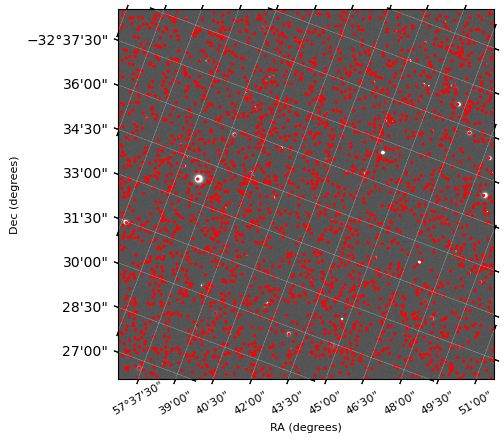

In [11]:
# config.thresholdValue = 4
ax = new_calexp.plot()
for i in range(len(sources)):
    new_calexp.add_point(ax,sources[i]["coord_ra"].asDegrees(), sources[i]["coord_dec"].asDegrees(), r = 10)

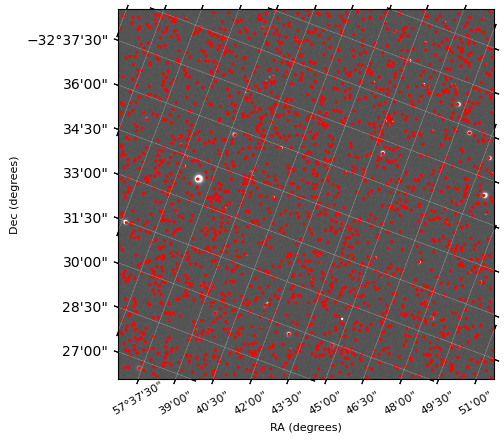

In [12]:
# measure task config.thresholdValue = 5
from lsst.afw import table as afwTable
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.algorithms import SourceDetectionTask
import lsst.daf.base as dafBase

schema = afwTable.SourceTable.makeMinimalSchema()
raerr = schema.addField("coord_raErr", type="F")
decerr = schema.addField("coord_decErr", type="F")
algMetadata = dafBase.PropertyList()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 5
config.thresholdType = "stdev"
detection_task = SourceDetectionTask(schema=schema, config=config)
config = SingleFrameMeasurementTask.ConfigClass()
measurment_task = SingleFrameMeasurementTask(schema=schema,
                                                   config=config,
                                                   algMetadata=algMetadata)
# measure calexp
tab = afwTable.SourceTable.make(schema)
result = detection_task.run(tab, new_calexp.expF)
sources = result.sources
# sources = calexp.get_sources(self.tasks["Detection"], schema)
measurment_task.run(measCat=sources, exposure=new_calexp.expF)

ax = new_calexp.plot()
for i in range(len(sources)):
    new_calexp.add_point(ax,sources[i]["coord_ra"].asDegrees(), sources[i]["coord_dec"].asDegrees(), r = 5)


(Measurement(value=20.59963930354939521, error=0.01518406234051837382),
 20.584455241208875,
 20.614823365889915,
 True)

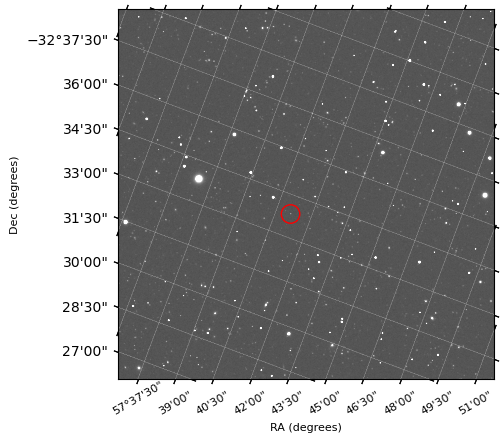

In [134]:
from lsst.geom import Angle, radians, degrees, SpherePoint
import numpy as np
ra_rad = Angle(ra, degrees).asRadians(); dec_rad = Angle(ra, degrees).asRadians()
near = np.argmin([SpherePoint(ra,dec, degrees).separation(SpherePoint(sources["coord_ra"][i],sources["coord_dec"][i], radians)) for i in range(len(sources))])
ax = new_calexp.plot()
new_calexp.add_point(ax,sources[near]["coord_ra"].asDegrees(), sources[near]["coord_dec"].asDegrees(), r = 100)
flux = sources["base_PsfFlux_instFlux"][near]; flux_err = sources["base_PsfFlux_instFluxErr"][near]
photoCalib = new_calexp.expF.getPhotoCalib()
measure = photoCalib.instFluxToMagnitude(flux, flux_err)
measure, measure.value-measure.error, measure.value+measure.error, measure.value-measure.error < 20.6 < measure.value+measure.error

## Calexp basics data

In [136]:
exposureF = calexp.expF
width = exposureF.image.getWidth()
height = exposureF.image.getHeight()

print(f"Calexp size: {width} x {height} pixels")

Calexp size: 4072 x 4000 pixels


In [145]:
pixel_scale = exposureF.getWcs().getPixelScale()
pixel_scale_arcsec = pixel_scale.asArcseconds()
pixel_scale_deg = pixel_scale_arcsec / 3600.0
area_degrees_squared = width * height * (pixel_scale_deg ** 2)
print(f"Area of sky: {area_degrees_squared} deg²")
area_arcsec_squared = width * height * (pixel_scale_arcsec ** 2)
print(f"Area of sky: {area_arcsec_squared} arcsec²")
pixel_scale_arcmin = pixel_scale_arcsec / 60
area_arcmin_squared = width * height * (pixel_scale_arcmin ** 2)
print(f"Area of sky: {area_arcmin_squared} arcmin²")

Area of sky: 0.0500855905650362 deg²
Area of sky: 649109.2537228692 arcsec²
Area of sky: 180.30812603413037 arcmin²
